In [104]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
from functions import create_base, add_basket_info, add_coupon_info
from functions import get_baskets, get_coupons, get_prediction_index, get_3_files
from functions import split_4_way

# Loading datasets

In [105]:
baskets, coupons, prediction_index = get_3_files()

In [106]:
customers = (1950,2000)
n_customers = customers[1] - customers[0]

In [107]:
baskets = baskets[(baskets['customer'] > customers[0]) & (baskets['customer'] < customers[1])]

# Creating base

In [239]:
base = create_base(customers=range(*customers))

In [240]:
base['basket'] = base['week'].astype(str) + '_' +base['customer'].astype(str)

In [241]:
base = add_basket_info(base, baskets)

In [242]:
base = add_coupon_info(base, baskets, coupons)

# Creating categories

<AxesSubplot:>

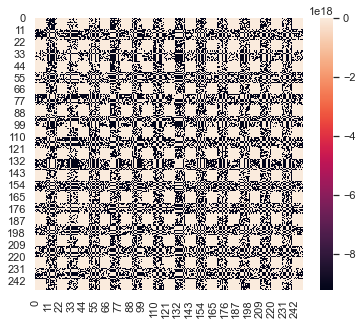

In [243]:
n_baskets = base['basket'].nunique()

matrix = np.matrix([np.array(base.iloc[x*250:x*250+250,5]) for x in range(n_baskets)]).astype(int)
occurency_matrix = matrix.T.dot(matrix)
occurency_matrix[occurency_matrix > 1] = 1

sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(occurency_matrix, annot=False)

<AxesSubplot:>

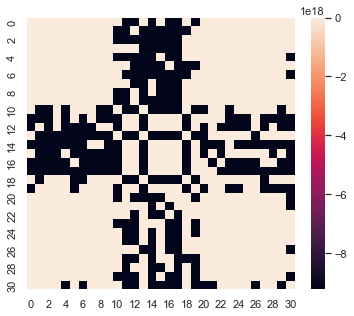

In [244]:
sns.heatmap(occurency_matrix[:31,:31], annot=False)

In [245]:
base['category'] = (base['product'] / 10).astype(int)

# Adding probabilities (product & category)

In [246]:
prod_probs_df = (
    baskets.groupby(['customer','product'])['week'].count() / 90) \
    .reset_index() \
    .rename(columns={'week':'probability'})
    
baskets['category'] = (baskets['product'].astype(int) / 10).astype(int)

cat_probs_df = (
    baskets.groupby(['customer','category'])['week'].count() / 90) \
    .reset_index() \
    .rename(columns={'week':'probability'})
    
base = pd.merge(base, prod_probs_df, on=['customer','product'] ,how='left')
base = pd.merge(base, cat_probs_df, on=['customer','category'] ,how='left')
base.rename(columns={'probability_x':'p_prod', 'probability_y':'p_cat'},inplace=True)

# Modelling

In [247]:
def split(df, train=True, week=89):
    return df[df['week']!=week] if train else df[df['week']==week]

y_train = split(base, train=True)['isBought'].values
y_test =  split(base, train=False)['isBought'].values

In [248]:
takes = lambda took, n0, n1: print(f'Will take {int((took / n0 * n1)/60)}m {int((took / n0 * n1)%60)}s ...')

In [249]:
base['p_prod'] = base['p_prod'].fillna(0)
base['p_cat'] = base['p_cat'].fillna(0)

base2 = base[['week','product','dGiven','isBought','isGiven','p_prod','p_cat']]
x_train, y_train, x_test, y_test = split_4_way(base2, target_col='isBought', unkwown_week=89)

In [314]:
takes(6.9,50,n_customers)
model = linear_model.LogisticRegression() #0.087 - 7.3 min
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

Will take 0m 6s ...
Loss: 0.082


In [315]:
takes(153,100,n_customers)
model = ensemble.GradientBoostingClassifier() #0.071 -> 0.066
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

Will take 1m 16s ...
Loss: 0.066


freq_prod_5
freq_prod_10
freq_prod_30
freq_prod_all

freq_cat_5
freq_cat_10
freq_cat_30
freq_cat_all

In [ ]:
def get_rolling_frequencies(n_weeks=5):
    
    rolling_df = pd.DataFrame()
    
    for week_nr in range(n_weeks,89+1):

        start = week_nr - n_weeks - 1
        end = week_nr

        single_week = (
            base[(start < base['week']) & (base['week'] < end)] 
            .groupby(['customer','product']) 
            .agg({'week':'last','isBought':'sum'}) 
            .reset_index()
            )
        
        single_week['week'] = single_week['week'] + 1
        single_week['isBought'] = single_week['isBought'] / n_weeks
        rolling_df = pd.concat([rolling_df, single_week])
    
    return rolling_df

In [318]:
def get_rolling_frequencies_category(n_weeks=5):
    
    rolling_df = pd.DataFrame()
    
    for week_nr in range(n_weeks,89+1):

        start = week_nr - n_weeks - 1
        end = week_nr

        single_week = (
            base[(start < base['week']) & (base['week'] < end)] 
            .groupby(['customer','category']) 
            .agg({'week':'last','isBought':'sum'}) 
            .reset_index()
            )
        
        single_week['week'] = single_week['week'] + 1
        single_week['isBought'] = single_week['isBought'] / n_weeks
        rolling_df = pd.concat([rolling_df, single_week])
    
    return rolling_df

#Week 5 looks at 0,1,2,3,4

In [326]:
rolled = get_rolling_frequencies(n_weeks=5).rename(columns={'isBought':'roll_prod_5'})
base2 = pd.merge(base, rolled, on=['week','customer','product'],how='left')

rolled = get_rolling_frequencies(n_weeks=10).rename(columns={'isBought':'roll_prod_10'})
base2 = pd.merge(base2, rolled, on=['week','customer','product'],how='left')

rolled = get_rolling_frequencies(n_weeks=30).rename(columns={'isBought':'roll_prod_30'})
base2 = pd.merge(base2, rolled, on=['week','customer','product'],how='left')

rolled = get_rolling_frequencies_category(n_weeks=5).rename(columns={'isBought':'roll_cat_5'})
base2 = pd.merge(base2, rolled, on=['week','customer','category'],how='left')

rolled = get_rolling_frequencies_category(n_weeks=10).rename(columns={'isBought':'roll_cat_10'})
base2 = pd.merge(base2, rolled, on=['week','customer','category'],how='left')

rolled = get_rolling_frequencies_category(n_weeks=30).rename(columns={'isBought':'roll_cat_30'})
base2 = pd.merge(base2, rolled, on=['week','customer','category'],how='left')

In [329]:
base2.loc[:,'roll_prod_5':] = base2.loc[:,'roll_prod_5':].fillna(0)

In [330]:
base2

,week,customer,product,basket,price,category,isBought,dGiven,isGiven,isUsed,p_prod,p_cat,roll_prod_5,roll_prod_10,roll_prod_30,roll_cat_5,roll_cat_10,roll_cat_30
0,0,1950,0,0_1950,0,0,False,0,False,False,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0,1950,1,0_1950,0,0,False,0,False,False,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0,1950,2,0_1950,0,0,False,0,False,False,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0,1950,3,0_1950,0,0,False,0,False,False,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0,1950,4,0_1950,0,0,False,0,False,False,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124995,89,1999,245,89_1999,549,24,True,0,False,False,0.133333,0.622222,0.0,0.0,0.133333,0.2,0.6,0.666667
1124996,89,1999,246,89_1999,0,24,False,30,True,False,0.000000,0.622222,0.0,0.0,0.000000,0.2,0.6,0.666667
1124997,89,1999,247,89_1999,0,24,False,0,False,False,0.000000,0.622222,0.0,0.0,0.000000,0.2,0.6,0.666667
1124998,89,1999,248,89_1999,0,24,False,0,False,False,0.000000,0.622222,0.0,0.0,0.000000,0.2,0.6,0.666667


In [469]:
base3 = base2.drop(['price','isUsed','basket'],axis=1)
x_train, y_train, x_test, y_test = split_4_way(base3, target_col='isBought', unkwown_week=89)

In [ ]:
#takes(153,100,n_customers)
model = ensemble.RandomForestClassifier() #0.071 -> 0.066 ->
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

# Feauture: Weeks ago bought (per product and per category)

In [467]:
only_bought = base3[base3['isBought']==1]
pairs = only_bought.groupby(['customer','product']).size().reset_index(inplace=False)

In [456]:
def buy_weeks_to_ago(buy_weeks):
    
    weeks_past = 90
    val = []
    bought = False

    for i in range(90):
        if i in buy_weeks:
            weeks_past = 0
            val.append(weeks_past)
            bought = True
        elif(bought==True): 
            weeks_past += 1 
            val.append(weeks_past)
        else:
            val.append(90)
    
    return val

In [460]:
all_pairs = pd.DataFrame()

for i in range(len(pairs)):
    customer = pairs.iloc[i,0]
    product = pairs.iloc[i,1]
    
    df = pd.DataFrame({
        'week':range(90),
        'customer':customer, 
        'product':product, 
        })
    
    buy_weeks = list(only_bought[(only_bought['product']==product) & (only_bought['customer']==customer)]['week'])
    df['weeks_ago'] = buy_weeks_to_ago(buy_weeks)
    all_pairs = pd.concat([all_pairs,df])
    
base3 = pd.merge(base3, all_pairs, on=['week','customer','product'],how='left').fillna(90)